## Pymultifracs:<br> python multifractal analysis toolbox

In [33]:
%matplotlib inline

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", context='notebook')
figure_folder = 'figures/fBm/'

import numpy as np

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
from scipy.io import loadmat

### Let's simulate a couple signals

In [35]:
from pymultifracs.simul import mrw, fbm

X_fbm = np.diff(fbm(shape=65536, H=0.8))
X_mrw = np.diff(mrw(shape=65536, H=0.8, lam=np.sqrt(0.03), L=65536))

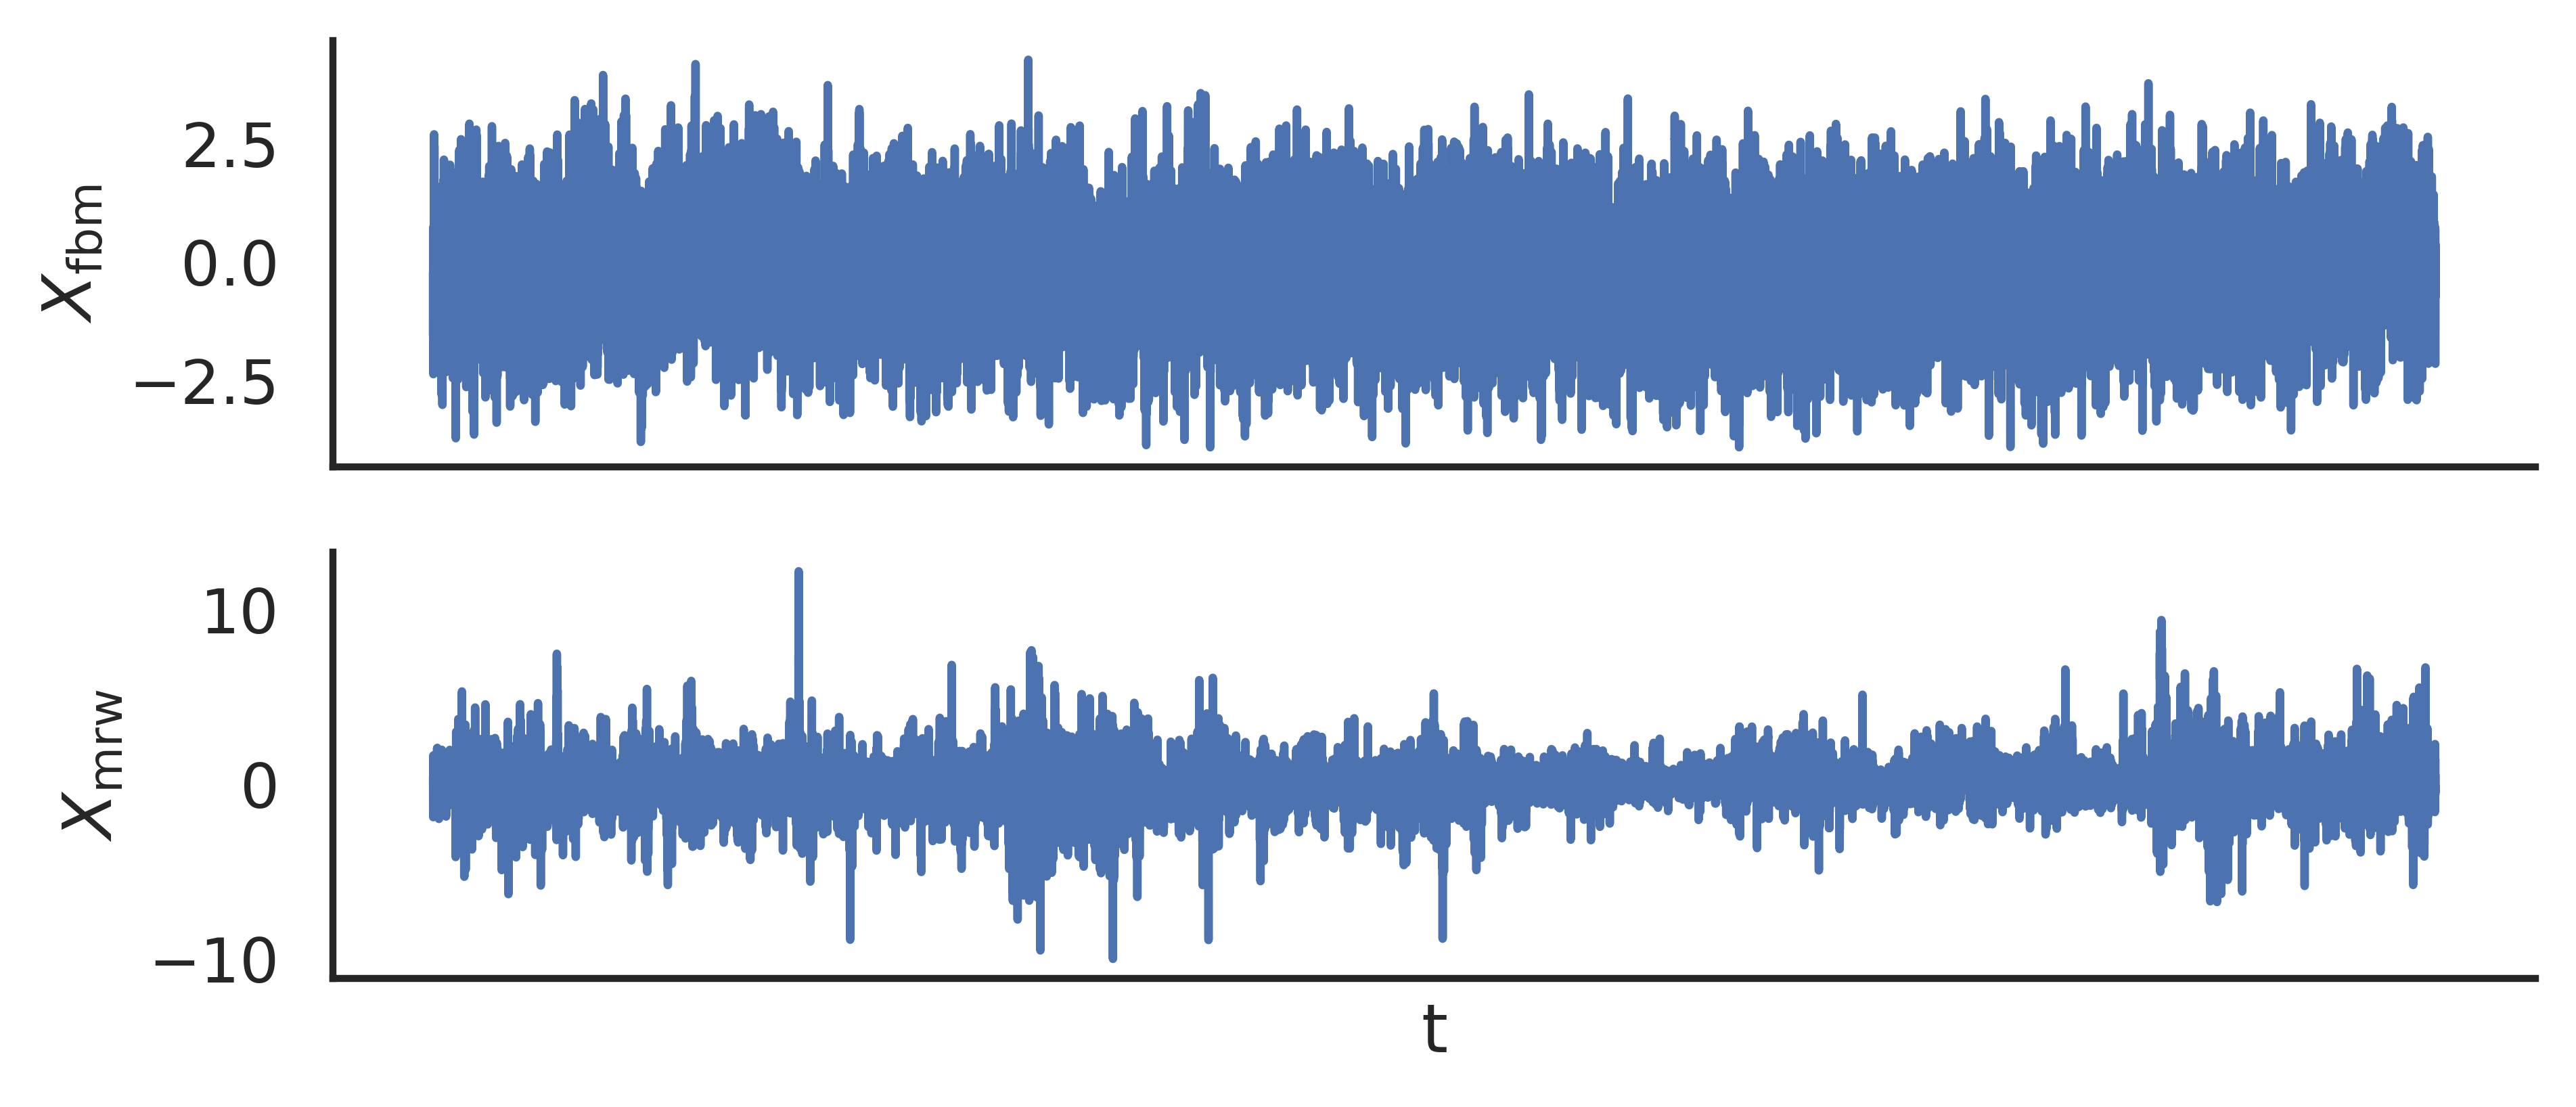

In [36]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 3))
ax[0].plot(X_fbm / np.std(X_fbm))
ax[0].set(ylabel='$X_{\mathrm{fbm}}$')
ax[1].plot(X_mrw / np.std(X_mrw))
ax[1].set(ylabel='$X_{\mathrm{mrw}}$', xlabel='t', xticks=[])
sns.despine()

## Wavelet analysis

In [37]:
from pymultifracs.wavelet import wavelet_analysis

WT_fbm = wavelet_analysis(X_fbm, p_exp=2, wt_name='db3', j1=2, j2_reg=11, gamint=1)
WT_mrw = wavelet_analysis(X_mrw, p_exp=2, wt_name='db3', j1=2, j2_reg=11, gamint=1)

WT_fbm.eta_p, WT_mrw.eta_p

(array([1.59147491]), array([1.63769491]))

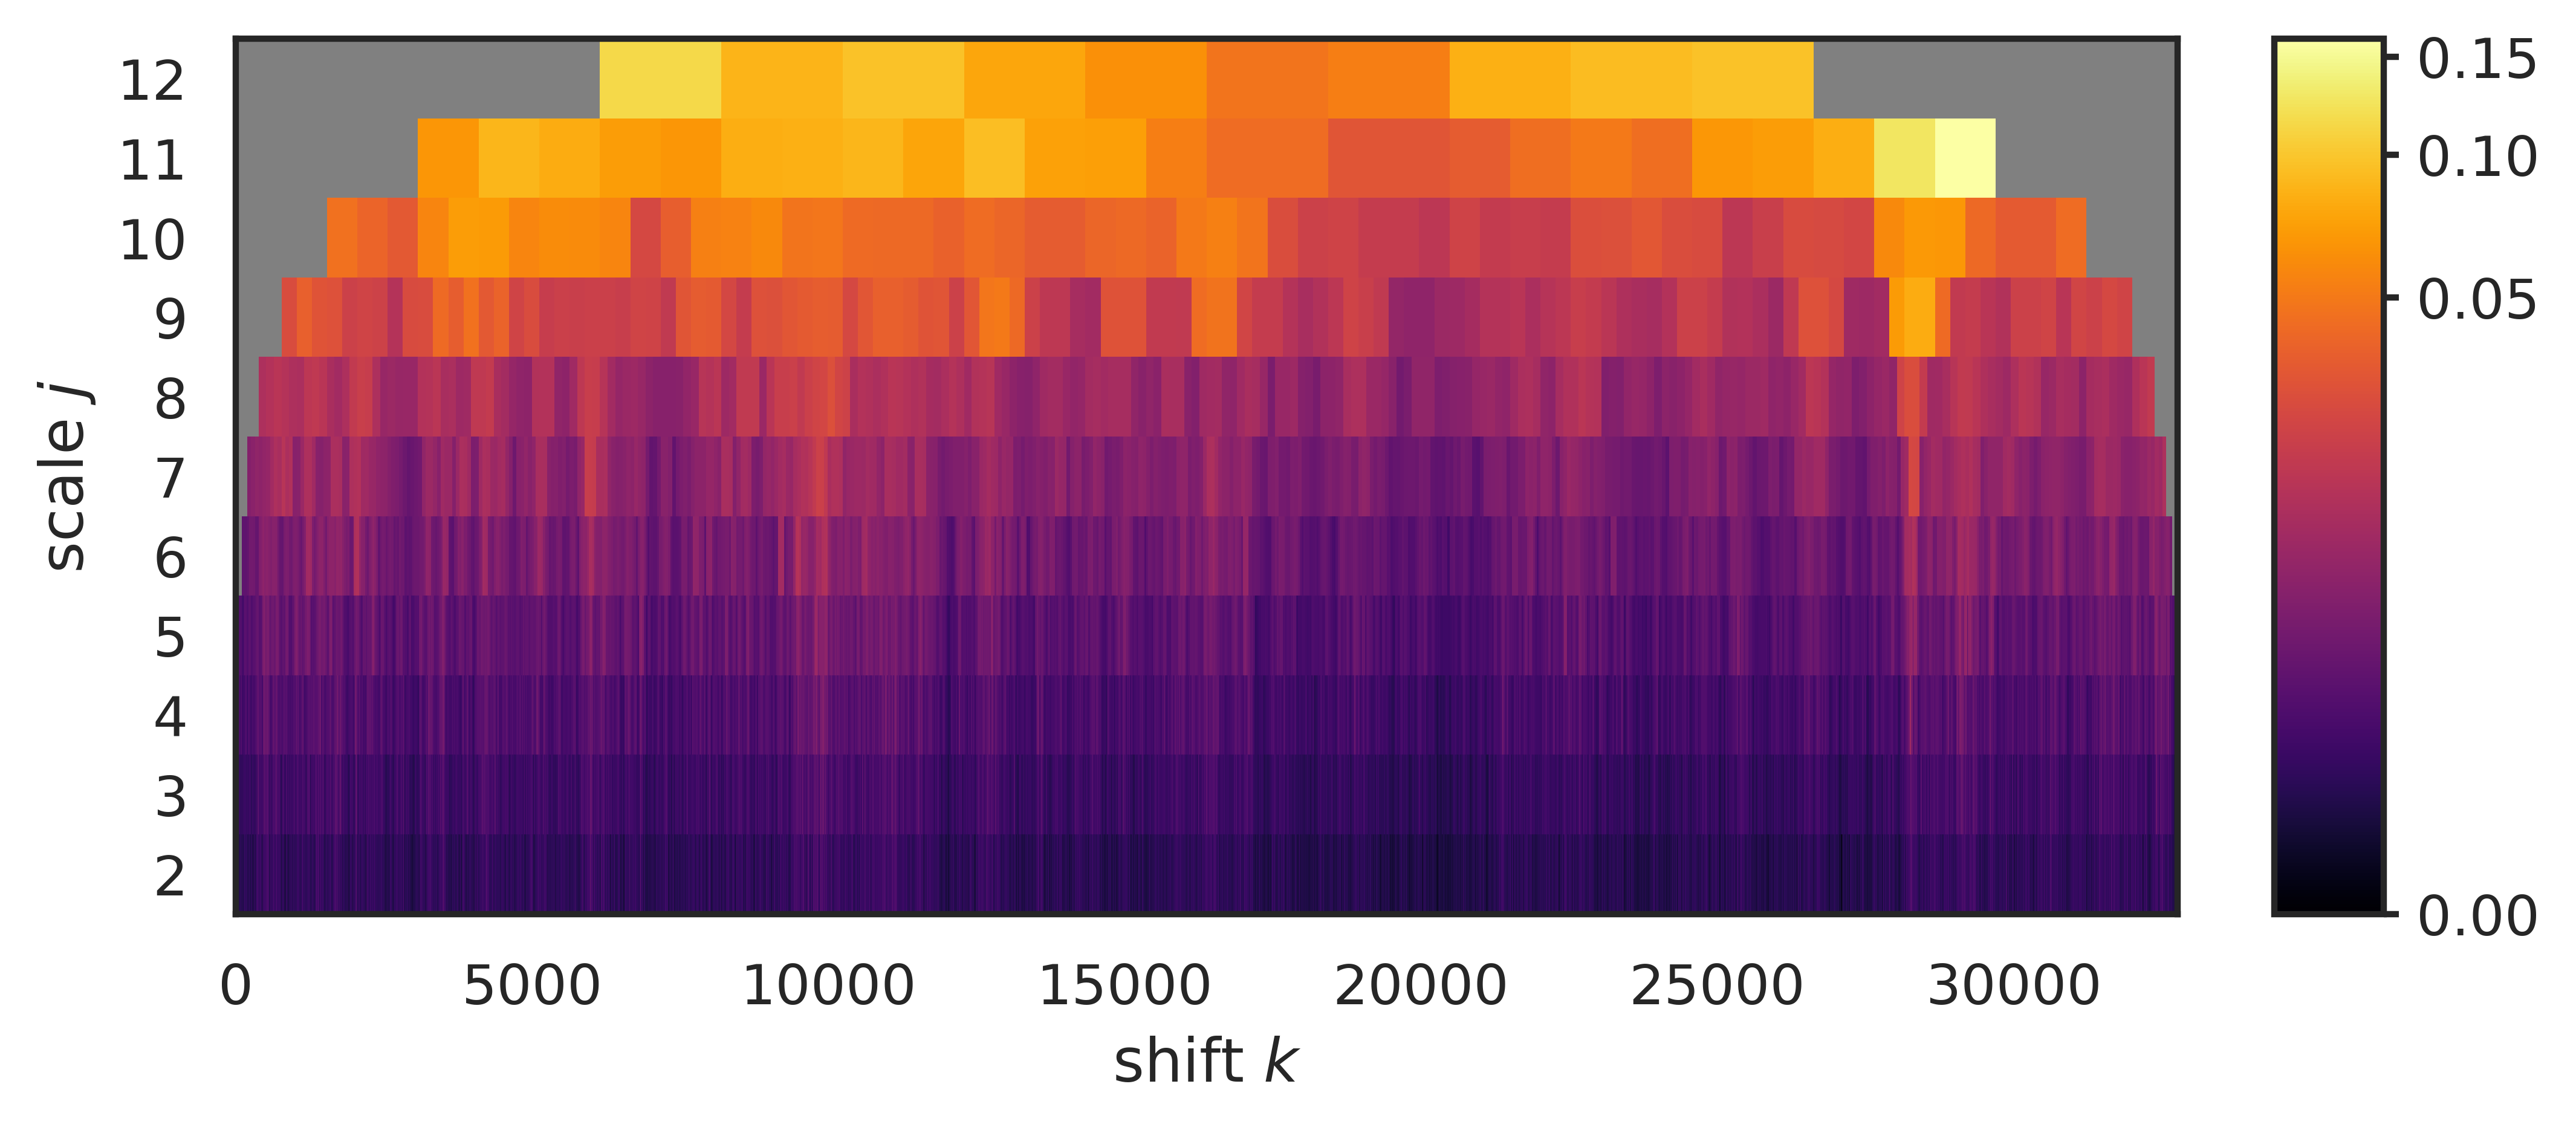

In [38]:
from pymultifracs.viz import plot_coef

plot_coef(WT_mrw.wt_leaders.values, j1=2, j2=12, figsize=(7, 3))

## Multifractal analysis

In [3]:
from pymultifracs.mfa import mf_analysis

lwt_fbm, lwt_mrw = mf_analysis(
    [WT_fbm.wt_leaders, WT_mrw.wt_leaders], [(2, 11)], n_cumul=2, q=[2])

NameError: name 'WT_fbm' is not defined

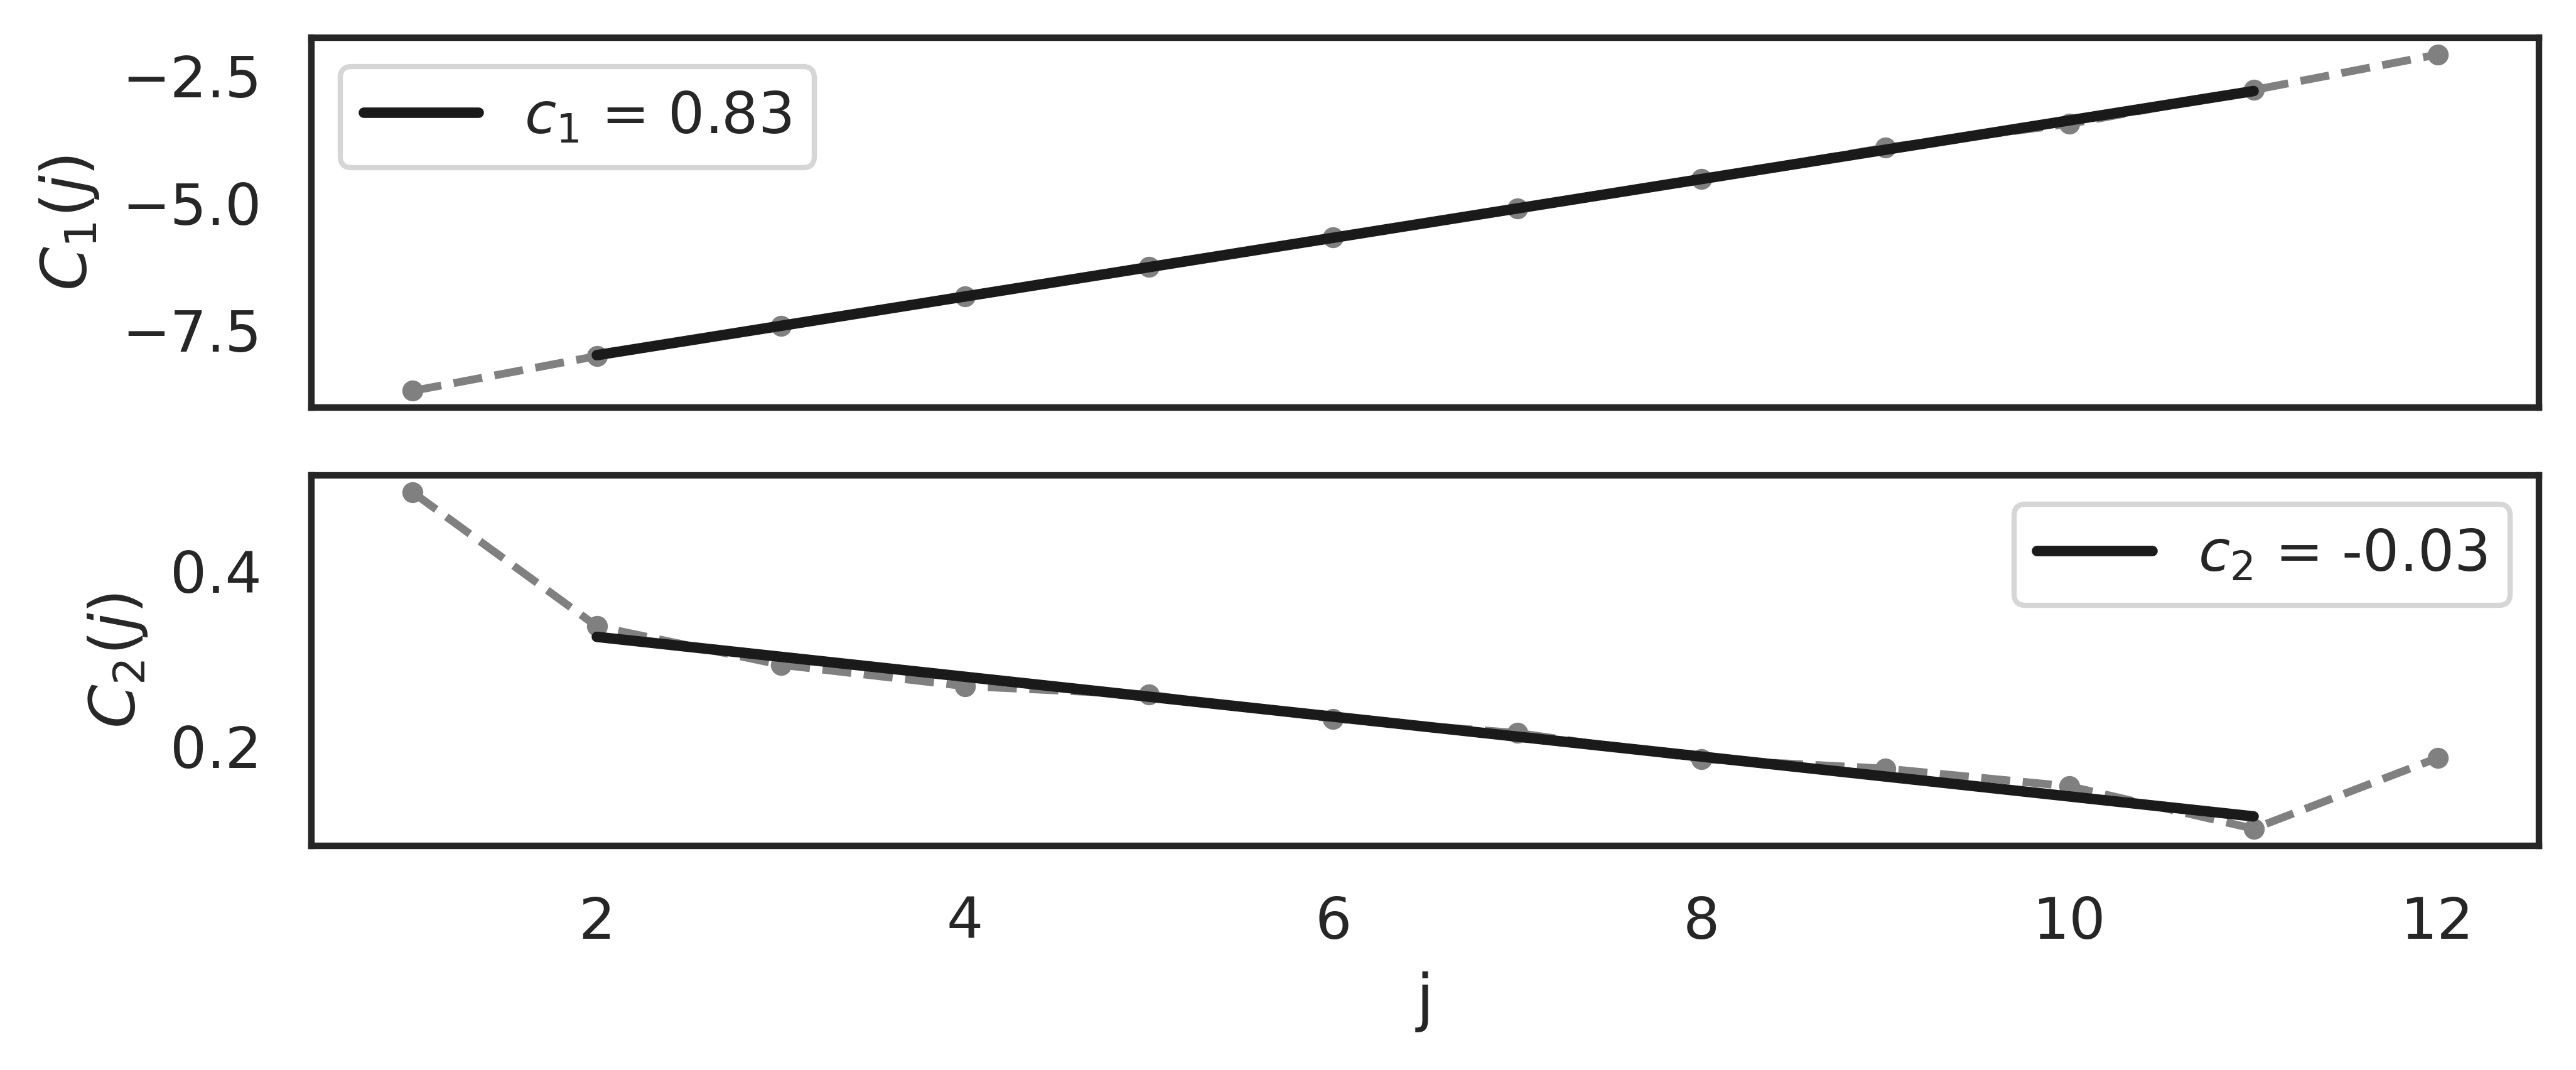

In [37]:
lwt_mrw.cumulants.plot(figsize=(7, 3))

## Utility functions

In [11]:
from pymultifracs.utils import scale2freq, freq2scale

print(freq2scale(freq=0.01, sfreq=1000))
print(scale2freq(scale=10, sfreq=1000))

16.194602975157967
0.732421875


## Practical example on MEG

Load a recording: Open neuro MIND data (`ds004107`)

subject `sub-mind002`, session `ses-02`, resting state recording

Already processed: maxwell filtering + notch filter + ICA denoising

Available at [filesender](https://filesender.renater.fr/?s=download&token=5caa63f0-2f8b-4323-bef6-f060a6b225e6)

In [5]:
raw = loadmat('raw_ica.mat')

data = raw['data'].transpose()
sfreq = raw['sfreq']

Let's figure out which scale to start the analysis from

In [13]:
freq2scale(1, sfreq)

array([[10.39303043]])

We need to figure out the value of $\eta_p$, in order to determine if (fractional) integration is necessary

In [32]:
WT = wavelet_analysis(data[:, :20], p_exp=2, j1=10, j2_reg=15, gamint=0)

/home/merlin/Multifracs/pymultifracs/pymultifracs/wavelet.py:52: UserWarning: eta(p) = [ 0.28674639  0.19557422  0.50253149  0.21922758  0.1481384   0.46942805
 -0.04400818  0.07789218  0.44407926  0.15186511  0.2363937   0.49270049
  0.19127878 -0.14133158  0.26937686  0.07745005 -0.25508375  0.18419158
 -0.08986371 -0.20649978] <= 0, p-Leaders correction was not                        applied. A smaller value of p (or larger value of                        gamint) should be selected.
  warnings.warn(f"eta(p) = {eta_p} <= 0, p-Leaders correction was not\


In [ ]:
WT = wavelet_analysis(data[:, :20], p_exp=2, j1=10, j2_reg=15, gamint=1)

/home/merlin/Multifracs/pymultifracs/pymultifracs/wavelet.py:52: UserWarning: eta(p) = [ 0.28674639  0.19557422  0.50253149  0.21922758  0.1481384   0.46942805
 -0.04400818  0.07789218  0.44407926  0.15186511  0.2363937   0.49270049
  0.19127878 -0.14133158  0.26937686  0.07745005 -0.25508375  0.18419158
 -0.08986371 -0.20649978] <= 0, p-Leaders correction was not                        applied. A smaller value of p (or larger value of                        gamint) should be selected.
  warnings.warn(f"eta(p) = {eta_p} <= 0, p-Leaders correction was not\


In [26]:
WT.eta_p

array([2.28674639, 2.19557422, 2.50253149, 2.21922758, 2.1481384 ,
       2.46942805, 1.95599182, 2.07789218, 2.44407926, 2.15186511,
       2.2363937 , 2.49270049, 2.19127878, 1.85866842, 2.26937686,
       2.07745005, 1.74491625, 2.18419158, 1.91013629, 1.79350022])

In [27]:
lwt = mf_analysis(WT.wt_leaders, [(10, 15)])

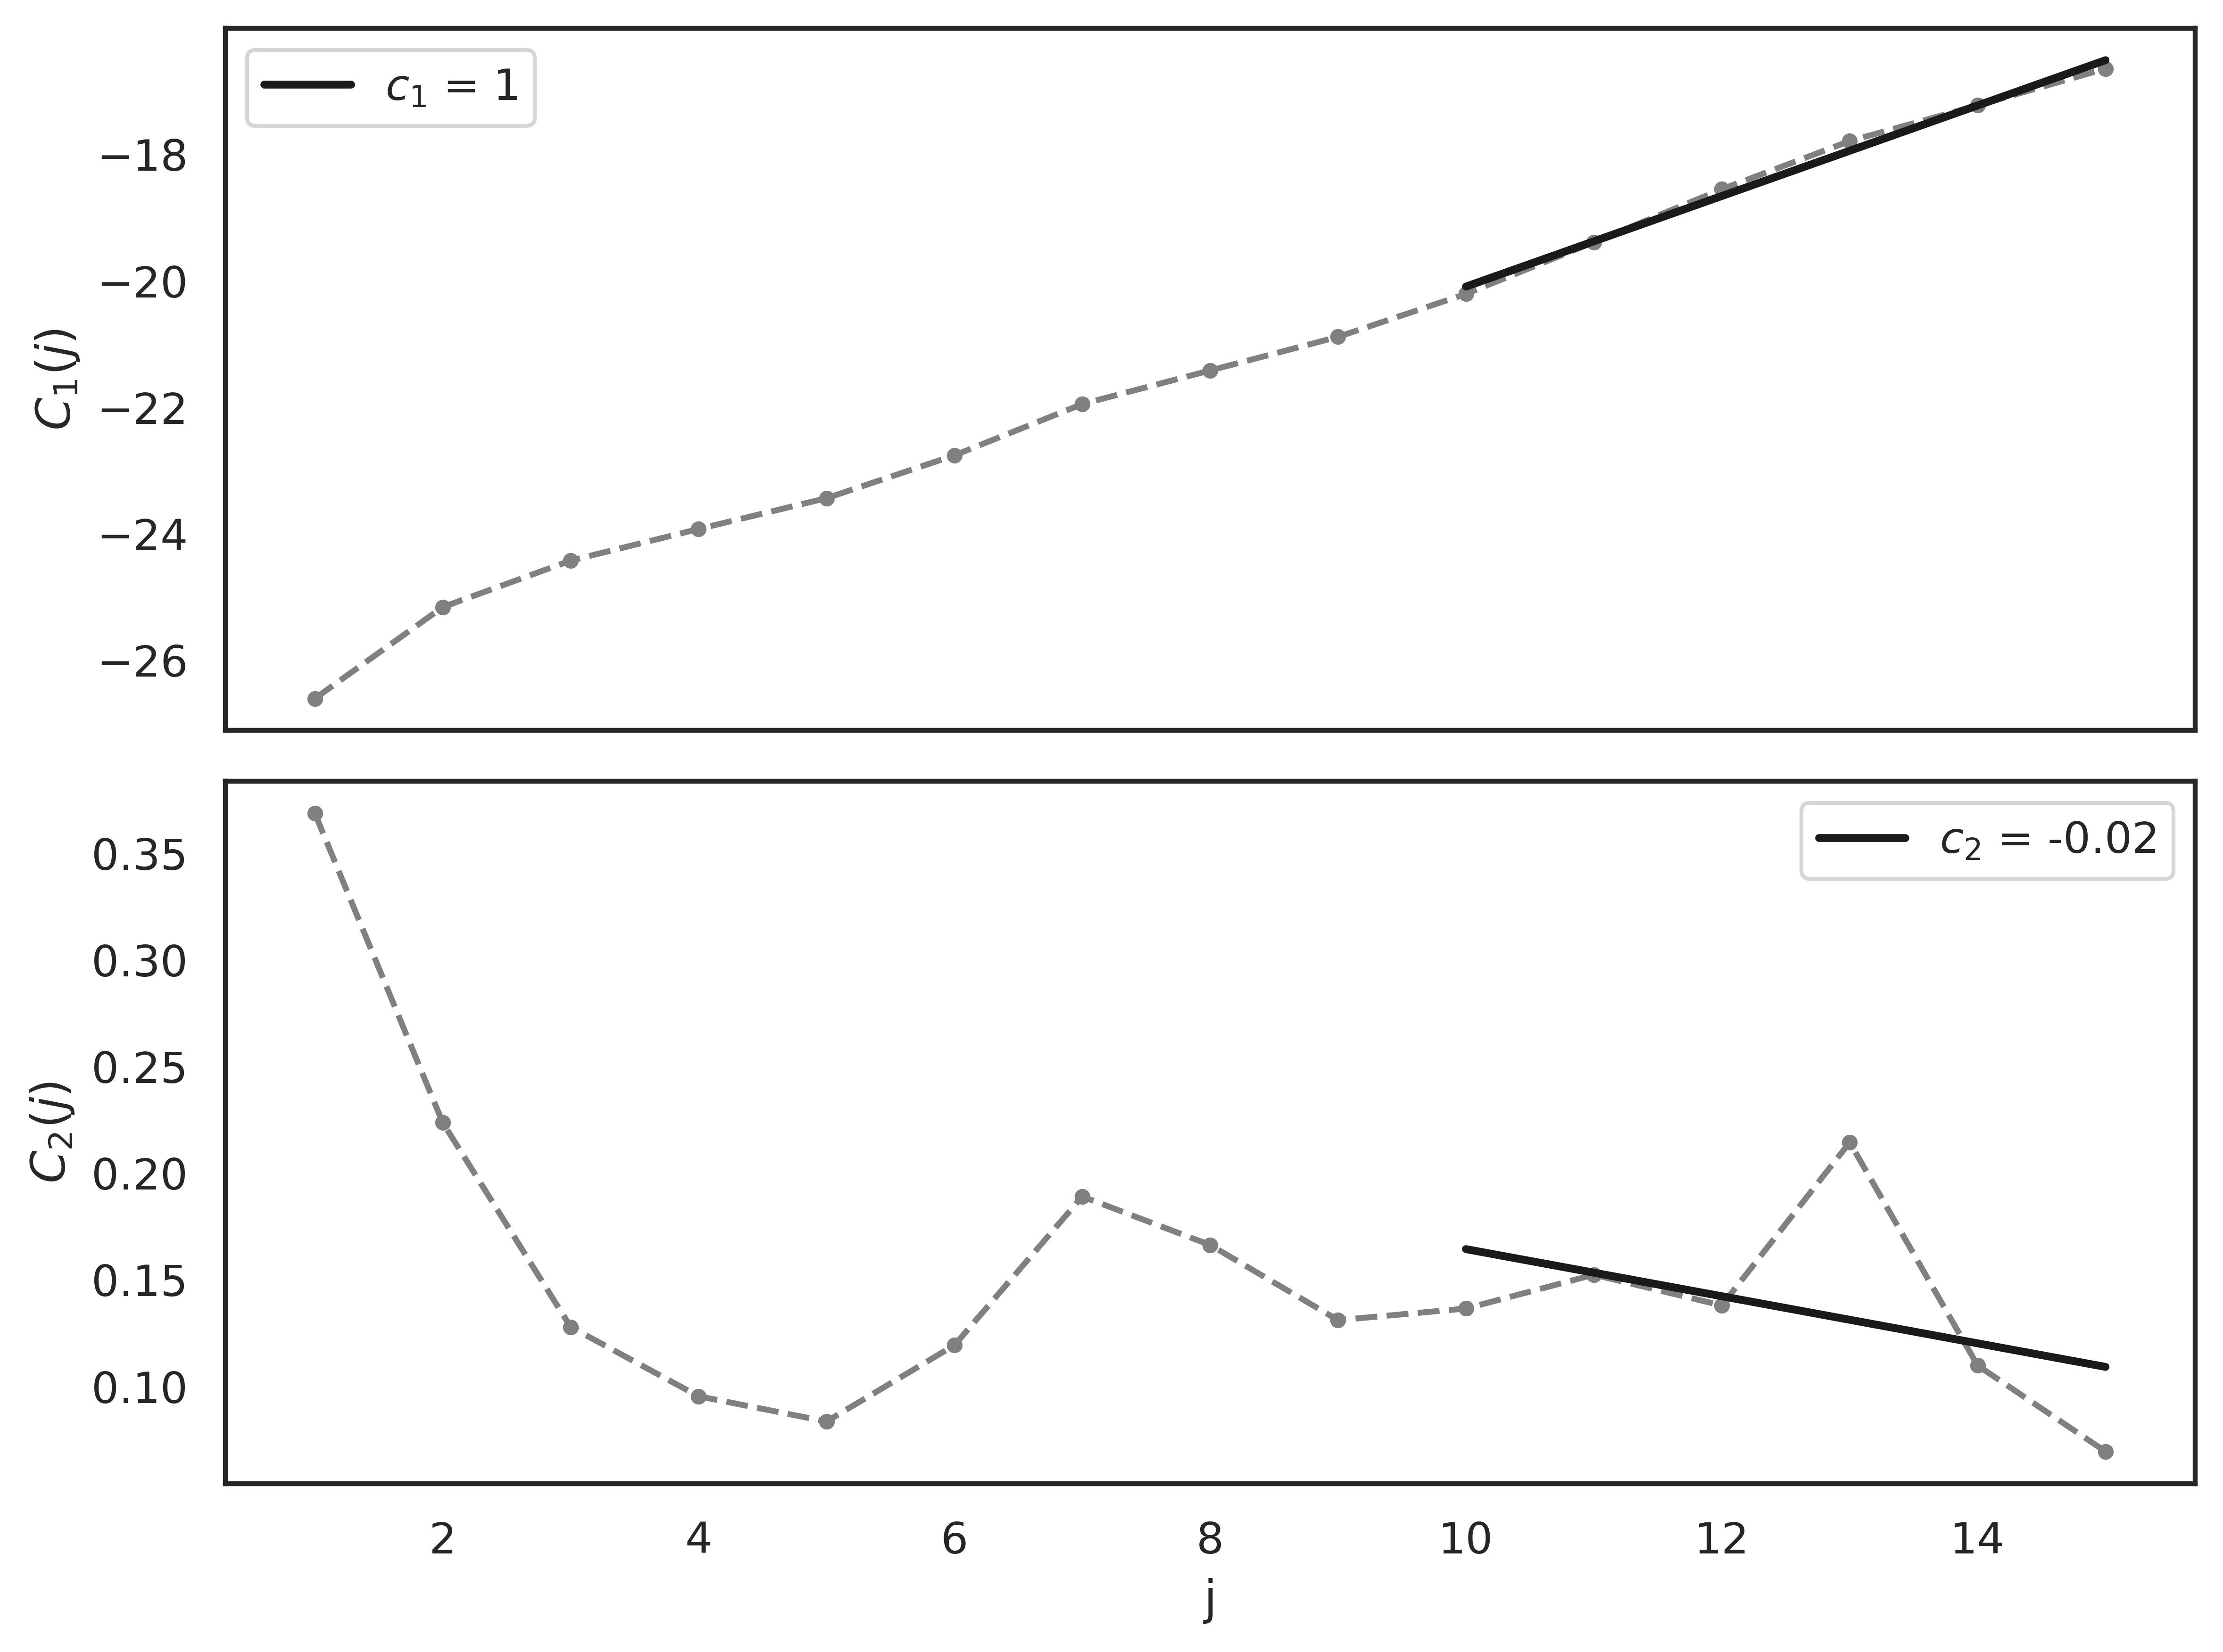

In [30]:
lwt.cumulants.plot(signal_idx=6)

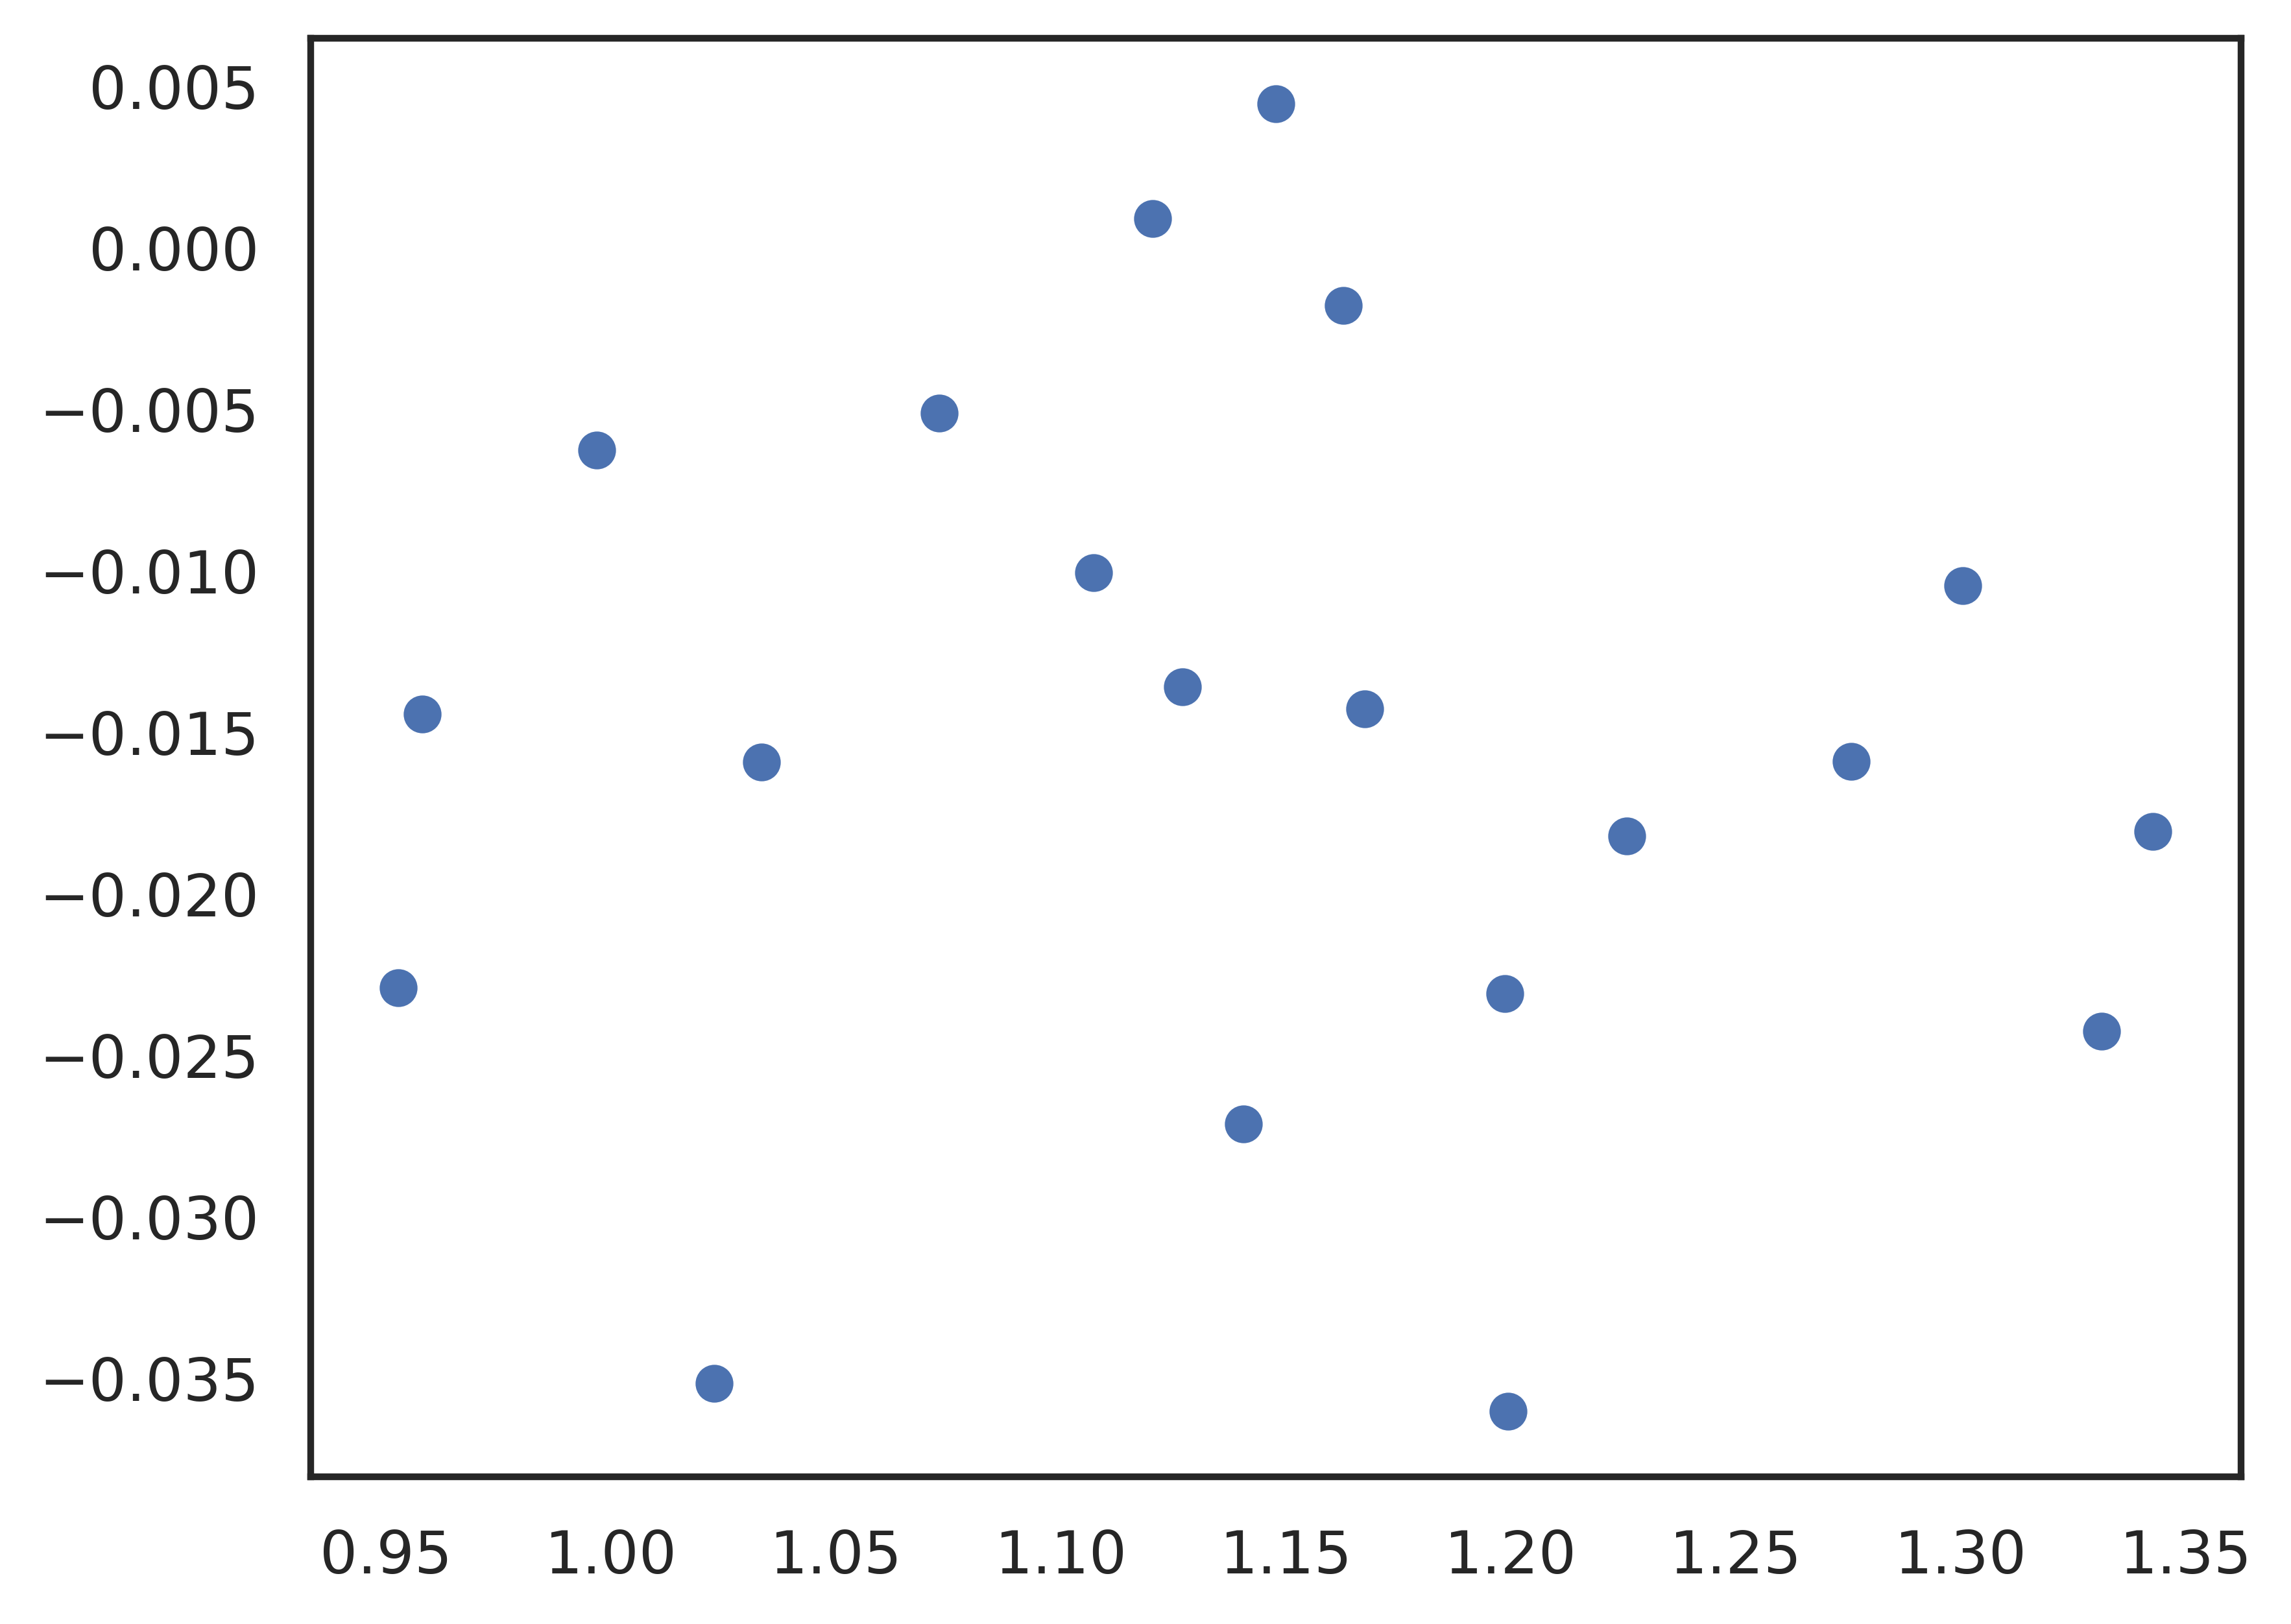

In [31]:
plt.scatter(lwt.cumulants.c1, lwt.cumulants.c2)

In [18]:
?mf_analysis

Signature:
mf_analysis(
    mrq,
    scaling_ranges,
    weighted=None,
    n_cumul=2,
    q=None,
    bootstrap_weighted=None,
    R=1,
    estimates='scm',
    robust=False,
    robust_kwargs=None,
)
Docstring:
Perform multifractal analysis, given wavelet coefficients.

Parameters
----------
mrq: :class:`MultiResolutionQuantity` | List[MultiResolutionQuantity]
    Multi-resolution quantity to analyze, or list of MRQs.
scaling_ranges: List[Tuple[int]]
    List of pairs of (j1, j2) ranges of scales for the analysis    
weighted : str | None
    Whether the linear regressions will be weighted
n_cumul : int
    Number of cumulants computed
q : ndarray, shape (n_exponents,)
    List of q values used in the multifractal analysis
bootstrap_weighted: str | None
    Whether the boostrapped mrqs will have weighted regressions
R: int
    Number of bootstrapped repetitions
estimates: str
    Quantities to estimate: string containing a character for each of:
        - "m": multifractal spectrum
 